In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

## Intro to dataset 

What is the problem? For loan provider it is important to ensure that people who get the loan can make the payment and don't default, however it is equally important that people are not denied a loan due to a model trained on poor quality data. 

We will read the data using pandas `read_csv` method

In [2]:
# Reading the data
df = pd.read_csv('../dataset/loan_prediction.csv')

"""Lets check the first 5 rows of the dataset. By adding the T at the end the column names will be represented as rows 
and the first 5 rows will be represented as columns"""
df.head().T

,0,1,2,3,4
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008
Gender,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate
Self_Employed,No,No,Yes,No,No
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,NaN,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0


In [3]:
# Converting loan term into months and classifying into categories
df['Loan_Amount_Term'] =  df['Loan_Amount_Term'].apply(lambda val: f"Month_{int(val/12)}" if str(val) != 'nan' else val)

In [4]:
# Lets also look at the high level stats of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [5]:
# Lets explore the distribution of all numerical columns.
# We will first extract the id column and the target column
id_col = 'Loan_ID'
target = 'Loan_Status'
cat_cols = [cols for cols in df if (df[cols].dtype == 'object' or cols == "credit_history") and cols not in [id_col, target]]
num_cols = [cols for cols in df if cols not in cat_cols + [id_col, target]]

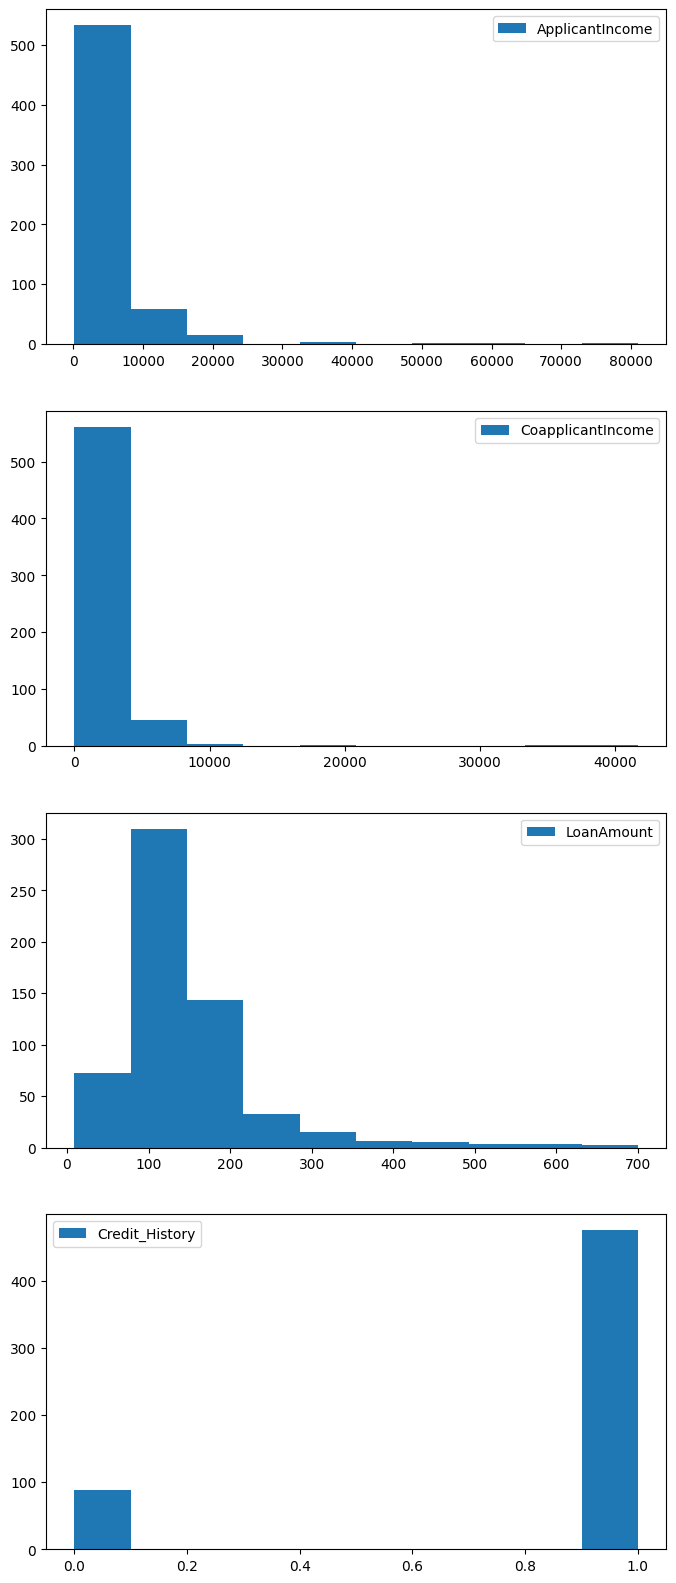

In [6]:
# Plotting distribution
fig, ax = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(8,20))
for cols, plot in zip(num_cols, ax):
    plot.hist(x=df[cols], bins=10, label=f"{cols}")
    plot.legend()

In [7]:
# The Loan amount is scaled down and represented in 1000s, we should either scale this up or scale ApplicationIncome and Coapplicationincome down
df.LoanAmount = df.LoanAmount*1000

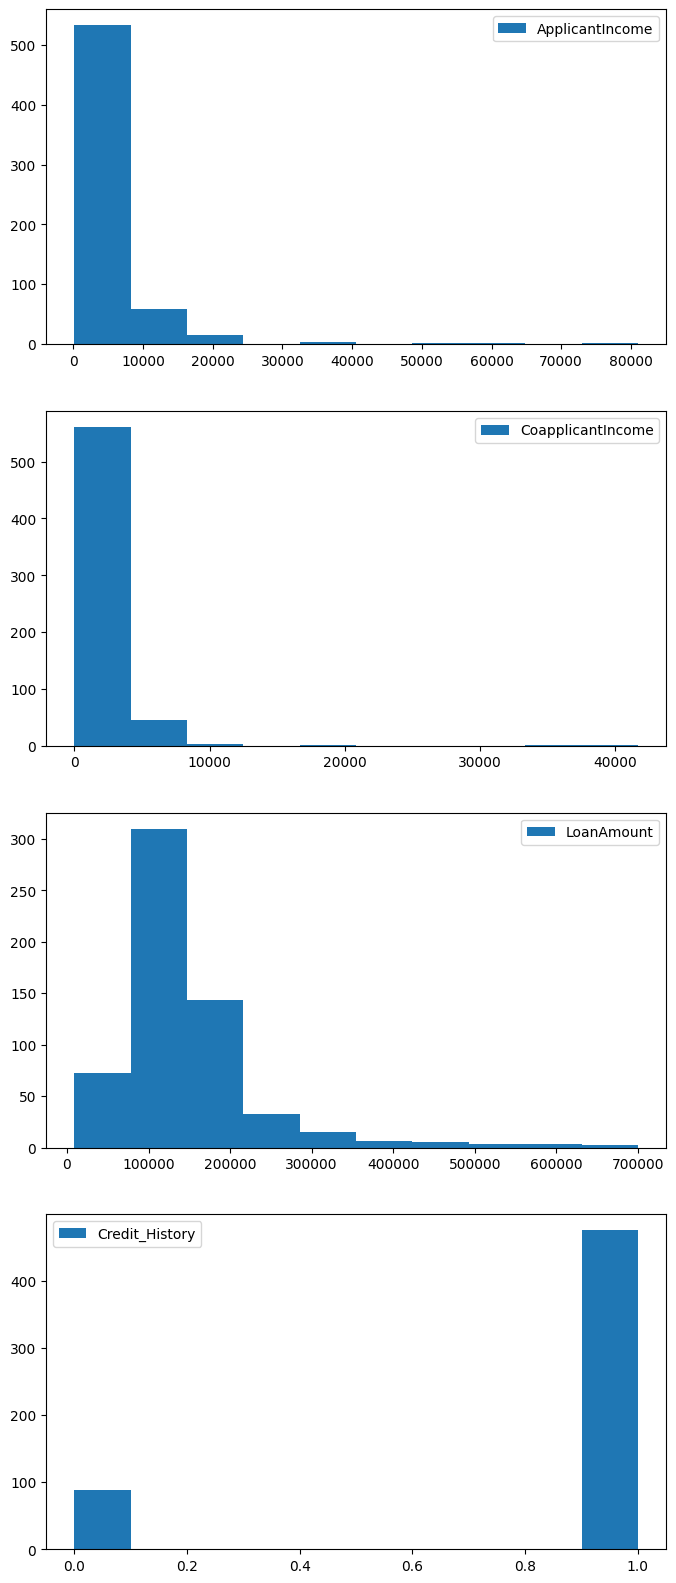

In [8]:
# Plotting distribution
fig, ax = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(8,20))
for cols, plot in zip(num_cols, ax):
    plot.hist(x=df[cols], bins=10, label=f"{cols}")
    plot.legend()

In [9]:
# Lets also check some numerical values have few unique values, then can be converted into categorical
for cols in num_cols:
    print(f"{cols} has n unique values compared to total values of {df.shape[0]}")
    print(df[cols].nunique())
    print()

ApplicantIncome has n unique values compared to total values of 614
505

CoapplicantIncome has n unique values compared to total values of 614
287

LoanAmount has n unique values compared to total values of 614
203

Credit_History has n unique values compared to total values of 614
2



In [10]:
# We will re run these as we have made some categorical
cat_cols = [cols for cols in df if (df[cols].dtype == 'object' or cols == "credit_history") and cols not in [id_col, target]]
num_cols = [cols for cols in df if cols not in cat_cols + [id_col, target]]

In [11]:
# The column names are inconsistent, lets make them clean

In [12]:
#Getting the column names
column_names = [cols for cols in df]
print(column_names)

['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


In [13]:
# We will now update the column names by adding underscore in long column names
df = df.rename(columns={'ApplicantIncome':'Applicant_Income', 
                        "CoapplicantIncome":"Co_Application_Income", 
                        "LoanAmount":"Loan_Amount"}
              )

In [14]:
# We will now make all columns lower case and in the next step update the columns
print([cols.lower() for cols in df])

['loan_id', 'gender', 'married', 'dependents', 'education', 'self_employed', 'applicant_income', 'co_application_income', 'loan_amount', 'loan_amount_term', 'credit_history', 'property_area', 'loan_status']


In [15]:
# Putting it together and updating the column names
df.columns = [cols.lower() for cols in df]
print(df.columns)

Index(['loan_id', 'gender', 'married', 'dependents', 'education',
       'self_employed', 'applicant_income', 'co_application_income',
       'loan_amount', 'loan_amount_term', 'credit_history', 'property_area',
       'loan_status'],
      dtype='object')


Within the data we can also see some categorical columns have data in in camel case and some data is separated by spaces and other times is separated by underscores. For instance `Gender` column has data in camel case, where the first letter is Upper and remaining characters are lower. Sometimes we can have inconsistencies within the same column. What happens if gender column has two distinct values for male customers, `Male` and `male`. If we don't treat this, then our machine learning model will consider `male` data points separate to `Male`, and the model will not get an accurate signal. We also have a education column, where data value of `Not Graduate` is separated by space. To ensure data consitency we must convert all data to lower case and replace spaces with underscores

In [16]:
id_col = 'loan_id'
target = 'loan_status'
cat_cols = [cols for cols in df if (df[cols].dtype == 'object' or cols == "credit_history") and cols not in [id_col, target]]
num_cols = [cols for cols in df if cols not in cat_cols + [id_col, target]]

In [17]:
# Lets iterate it over each categorical column and print the values
for col in cat_cols:
    print(f'Unique values for {col} column are: \n {df[col].unique()} \n\n')

Unique values for gender column are: 
 ['Male' 'Female' nan] 


Unique values for married column are: 
 ['No' 'Yes' nan] 


Unique values for dependents column are: 
 ['0' '1' '2' '3+' nan] 


Unique values for education column are: 
 ['Graduate' 'Not Graduate'] 


Unique values for self_employed column are: 
 ['No' 'Yes' nan] 


Unique values for loan_amount_term column are: 
 ['Month_30' 'Month_10' 'Month_20' nan 'Month_15' 'Month_5' 'Month_25'
 'Month_40' 'Month_3' 'Month_7' 'Month_1'] 


Unique values for credit_history column are: 
 [ 1.  0. nan] 


Unique values for property_area column are: 
 ['Urban' 'Rural' 'Semiurban'] 




In [18]:
# We can see the graduate column has two values , if they are a graduate or not. We can change the column from education to graduate and change the mapping to Yes or No
# Lets rename the columns and then lets apply 
df = df.rename(columns={'education':'graduate'})
df.graduate = df.graduate.map({'Graduate': 'Yes', 'Not Graduate': 'No'})

cat_cols = [cols for cols in df if (df[cols].dtype == 'object' or cols == "credit_history") and cols not in [id_col, target]]
num_cols = [cols for cols in df if cols not in cat_cols + [id_col, target]]

In [19]:
# Lets make the rest of the data consistent
def make_data_consistent(df, cols) -> pd.DataFrame:
    """Function to make data consistent and meaningful"""
    
    df = df.copy()
    
    for col in cols:
           
        # making all values lower case
        df[col] = df[col].apply(lambda val: val.lower() if isinstance(val, str) else val)

        # removing whitespace and '-' and replacing with '_'
        df[col] = df[col].apply(lambda val: val.replace('-','_').replace(' ','_') if isinstance(val, str) else val)
            
    
    # property_area column applying the custom update
    df['property_area'] = df['property_area'].map({
            'semiurban': 'semi_urban',
            'rural': 'rural',
            'urban': 'urban'
            })
    
    return df
    

df = make_data_consistent(df=df, cols=cat_cols+[id_col, target])

In [20]:
# Lets iterate it over each categorical column and print the values
for col in cat_cols:
    print(f'Unique values for {col} column are: \n {df[col].unique()} \n\n')

Unique values for gender column are: 
 ['male' 'female' nan] 


Unique values for married column are: 
 ['no' 'yes' nan] 


Unique values for dependents column are: 
 ['0' '1' '2' '3+' nan] 


Unique values for graduate column are: 
 ['yes' 'no'] 


Unique values for self_employed column are: 
 ['no' 'yes' nan] 


Unique values for loan_amount_term column are: 
 ['month_30' 'month_10' 'month_20' nan 'month_15' 'month_5' 'month_25'
 'month_40' 'month_3' 'month_7' 'month_1'] 


Unique values for credit_history column are: 
 [ 1.  0. nan] 


Unique values for property_area column are: 
 ['urban' 'rural' 'semi_urban'] 




In [21]:
# We can now convert all yes and no to 1 and 0, and binary encode these
binary_cols = ['married', 'graduate', 'self_employed']
for cols in binary_cols:
    df[cols] = df[cols].map({"yes":1, "no":0})
gender_col = 'gender'
df[gender_col] = df[gender_col].map({"male":1, "female":0})

# Lets also clean the target as we need numerical information for machine learning
df[target] = df[target].map({'y':1, 'n':0})

In [22]:
df.isnull().sum()

loan_id                   0
gender                   13
married                   3
dependents               15
graduate                  0
self_employed            32
applicant_income          0
co_application_income     0
loan_amount              22
loan_amount_term         14
credit_history           50
property_area             0
loan_status               0
dtype: int64

# 2. Handling Missing Values
Now we have achieved consistency with the data, its now time to identify other quality issues with the data and address those issues. One such issue is missing information in the data. Missing data are common problems with real data sets. As the dataset size increases, chance of data points missing in the data increases. 

In [23]:
# Percentage of data left by dropping all the missing data
remaining_rows = df.dropna(axis=0).shape[0]
total_records = df.shape[0]
perc_dropped = ((total_records - remaining_rows)/total_records)*100

print("By dropping all missing data, only {:,} records will be left out of {:,}, a reduction by {:,.3f}%".format(remaining_rows, total_records, perc_dropped))

By dropping all missing data, only 480 records will be left out of 614, a reduction by 21.824%


Since 21% is one-third of the dataset, is not a feasible method. Hence, in this section we will explore how to identify missing data, uncover patters or reasons of data being missing and discover techinuqes for handling missing data, so dataset can be used for machine learning

In [24]:
# To check if data is missing in the dataset, pandas provides a convenice method .info(). The method shows amongst the total records, how many are missing per column

df.info()

# Amongst the total records of 614, credit history has the lowest of 564

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loan_id                614 non-null    object 
 1   gender                 601 non-null    float64
 2   married                611 non-null    float64
 3   dependents             599 non-null    object 
 4   graduate               614 non-null    int64  
 5   self_employed          582 non-null    float64
 6   applicant_income       614 non-null    int64  
 7   co_application_income  614 non-null    float64
 8   loan_amount            592 non-null    float64
 9   loan_amount_term       600 non-null    object 
 10  credit_history         564 non-null    float64
 11  property_area          614 non-null    object 
 12  loan_status            614 non-null    int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 62.5+ KB


In [25]:
# Pandas has another convenience method .isnull() to check which row has missing information for a column and which one doesnt. By applying .sum(), we can get total number of missing records for each column.
df.isnull().sum()


loan_id                   0
gender                   13
married                   3
dependents               15
graduate                  0
self_employed            32
applicant_income          0
co_application_income     0
loan_amount              22
loan_amount_term         14
credit_history           50
property_area             0
loan_status               0
dtype: int64

In [26]:
def missing_data_percentage(df: pd.DataFrame):
    """Function to print percentage of missing values"""
    
    df = df.copy()
    
    missing_data = df.isnull().sum()
    total_records = df.shape[0]
    
    perc_missing = round((missing_data/total_records)*100, 3)
    
    missing_df = pd.DataFrame(data={'columm_name':perc_missing.index, 'perc_missing':perc_missing.values})
    
    return missing_df

# By utilising percentages, it is easier to credit_history has the majority of data missing, 8.14%
missing_data_percentage(df[cat_cols+num_cols]).sort_values(by='perc_missing', ascending=False)

,columm_name,perc_missing
6,credit_history,8.143
4,self_employed,5.212
10,loan_amount,3.583
2,dependents,2.443
5,loan_amount_term,2.280
0,gender,2.117
1,married,0.489
3,graduate,0.000
7,property_area,0.000
8,applicant_income,0.000


<AxesSubplot: >

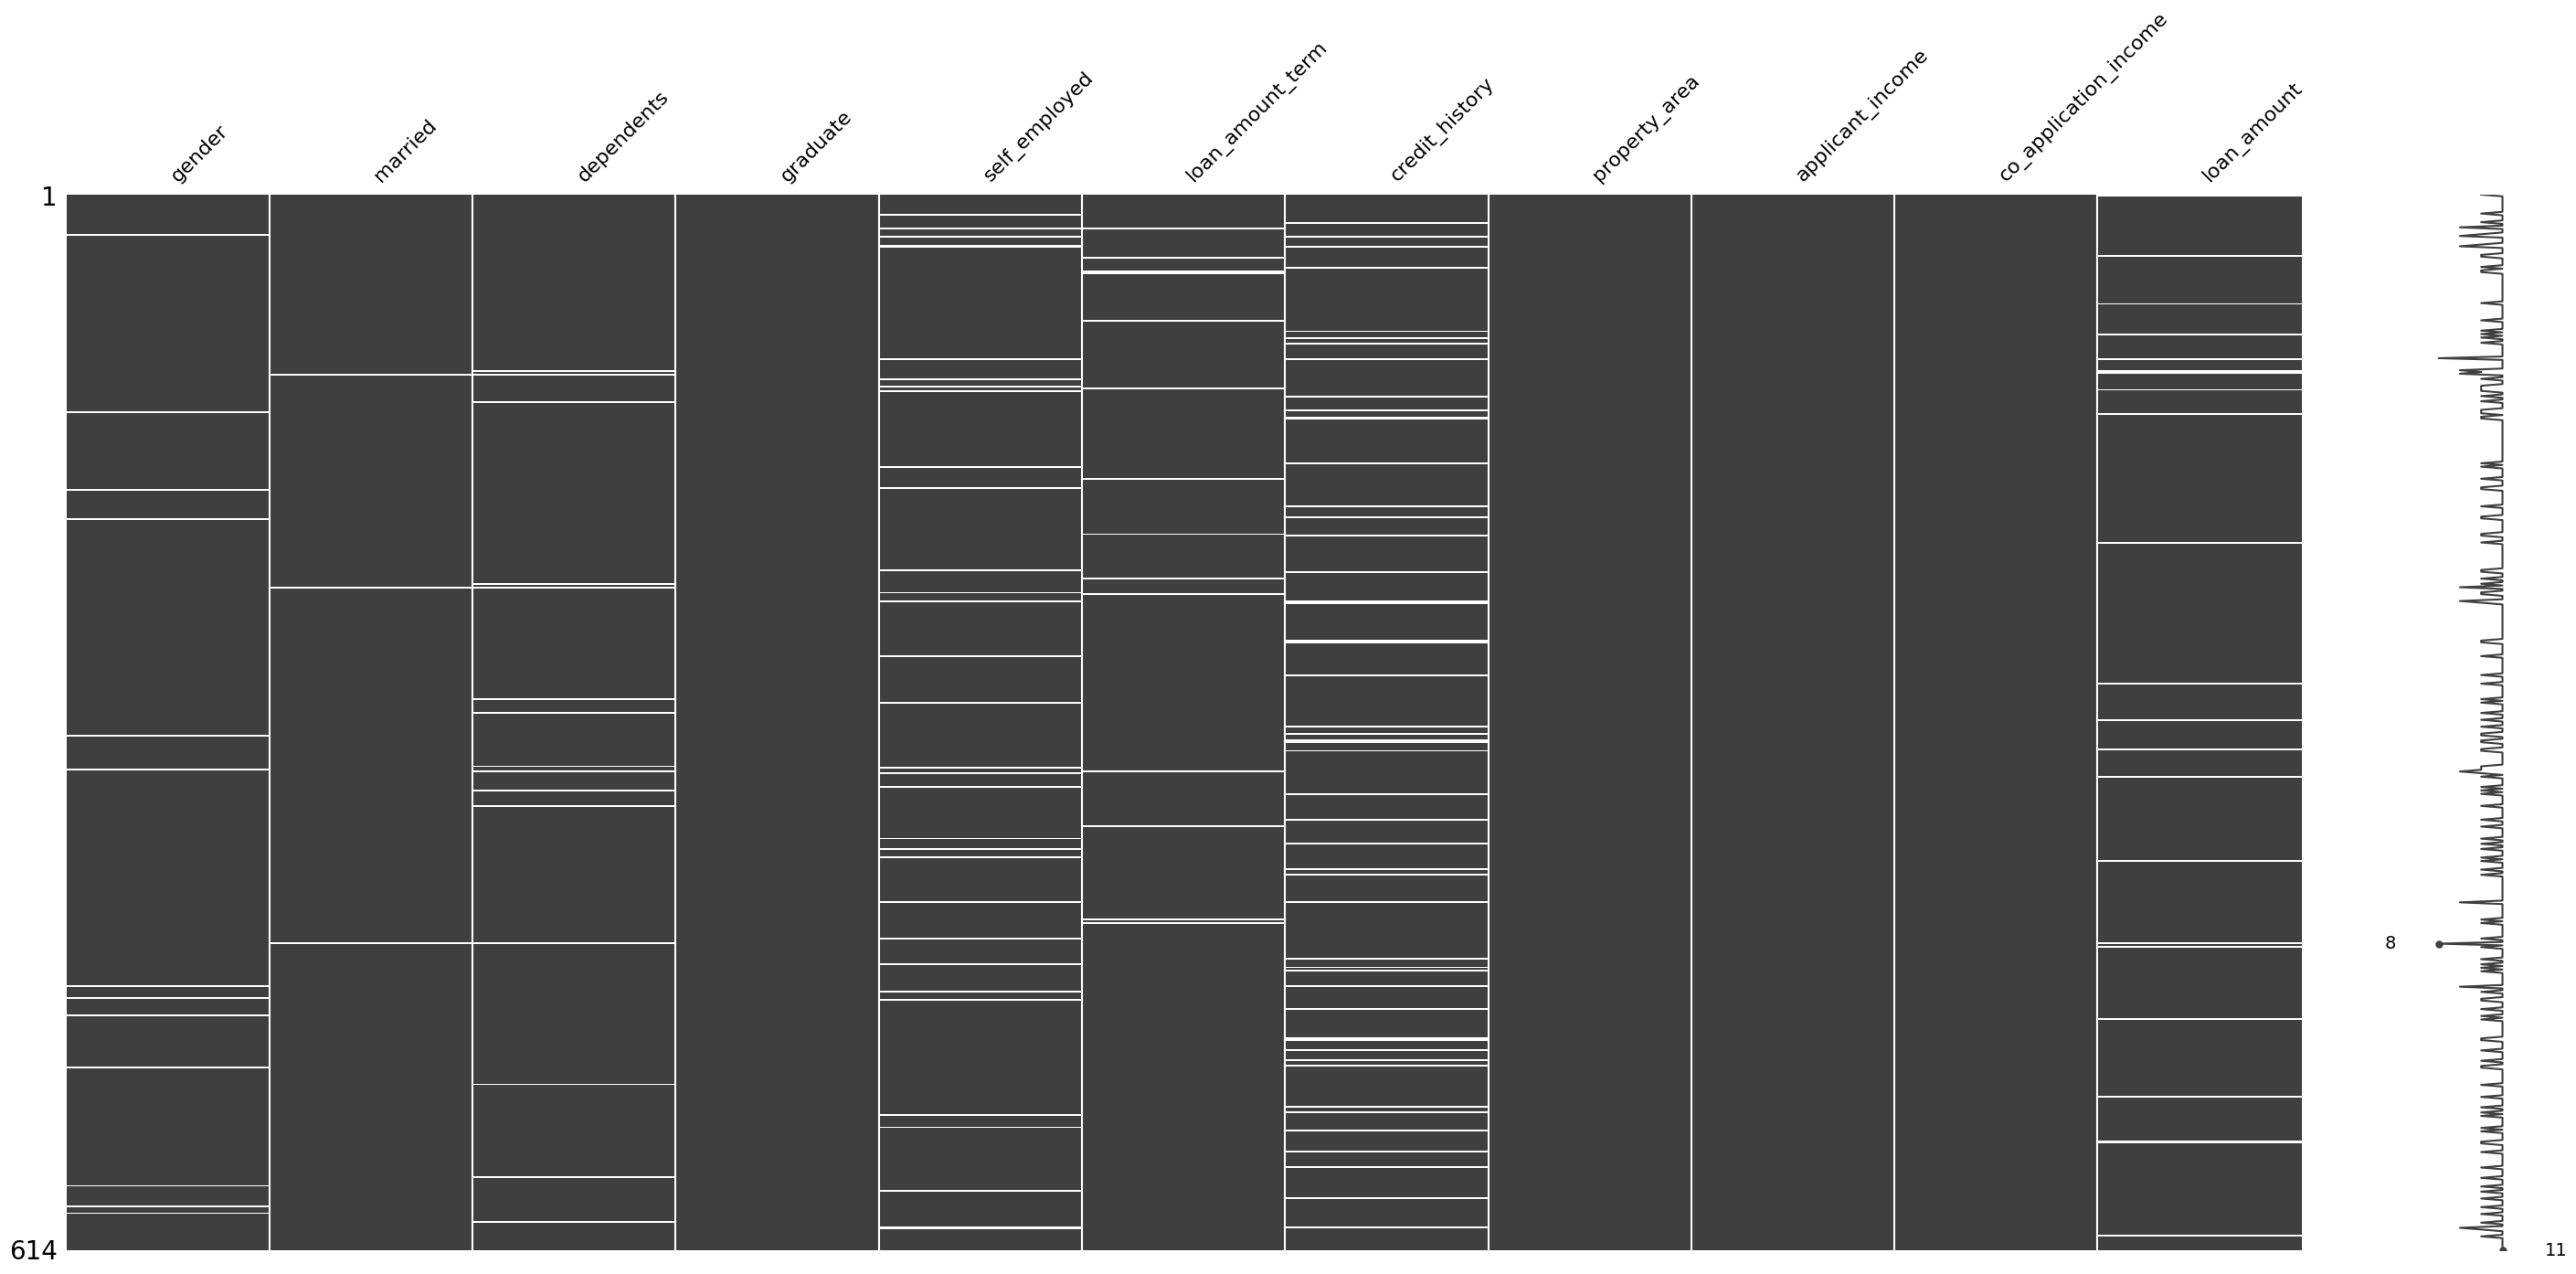

In [27]:
# Lets explore missing data
msno.matrix(df[cat_cols+num_cols], figsize=(35, 15))

Correlation heatmap measures nullity correlation between columns of the dataset. It shows how strongly the presence or absence of one feature affects the other.

Nullity correlation ranges from(-1 to 1):

- -1 means if one column(attribute) is present, the other is almost certainly absent.
- 0 means there is no dependence between the columns(attributes).
- 1 means if one column(attributes) is present, the other is also certainly present.
Unlike in a familiar correlation heatmap, if you see here, many columns are missing. Those columns which are always full or always empty have no meaningful correlation and are removed from the visualization.

The heatmap is helpful for identifying data completeness correlations between attribute pairs, but it has the limited explanatory ability for broader relationships and no special support for really big datasets.

<AxesSubplot: >

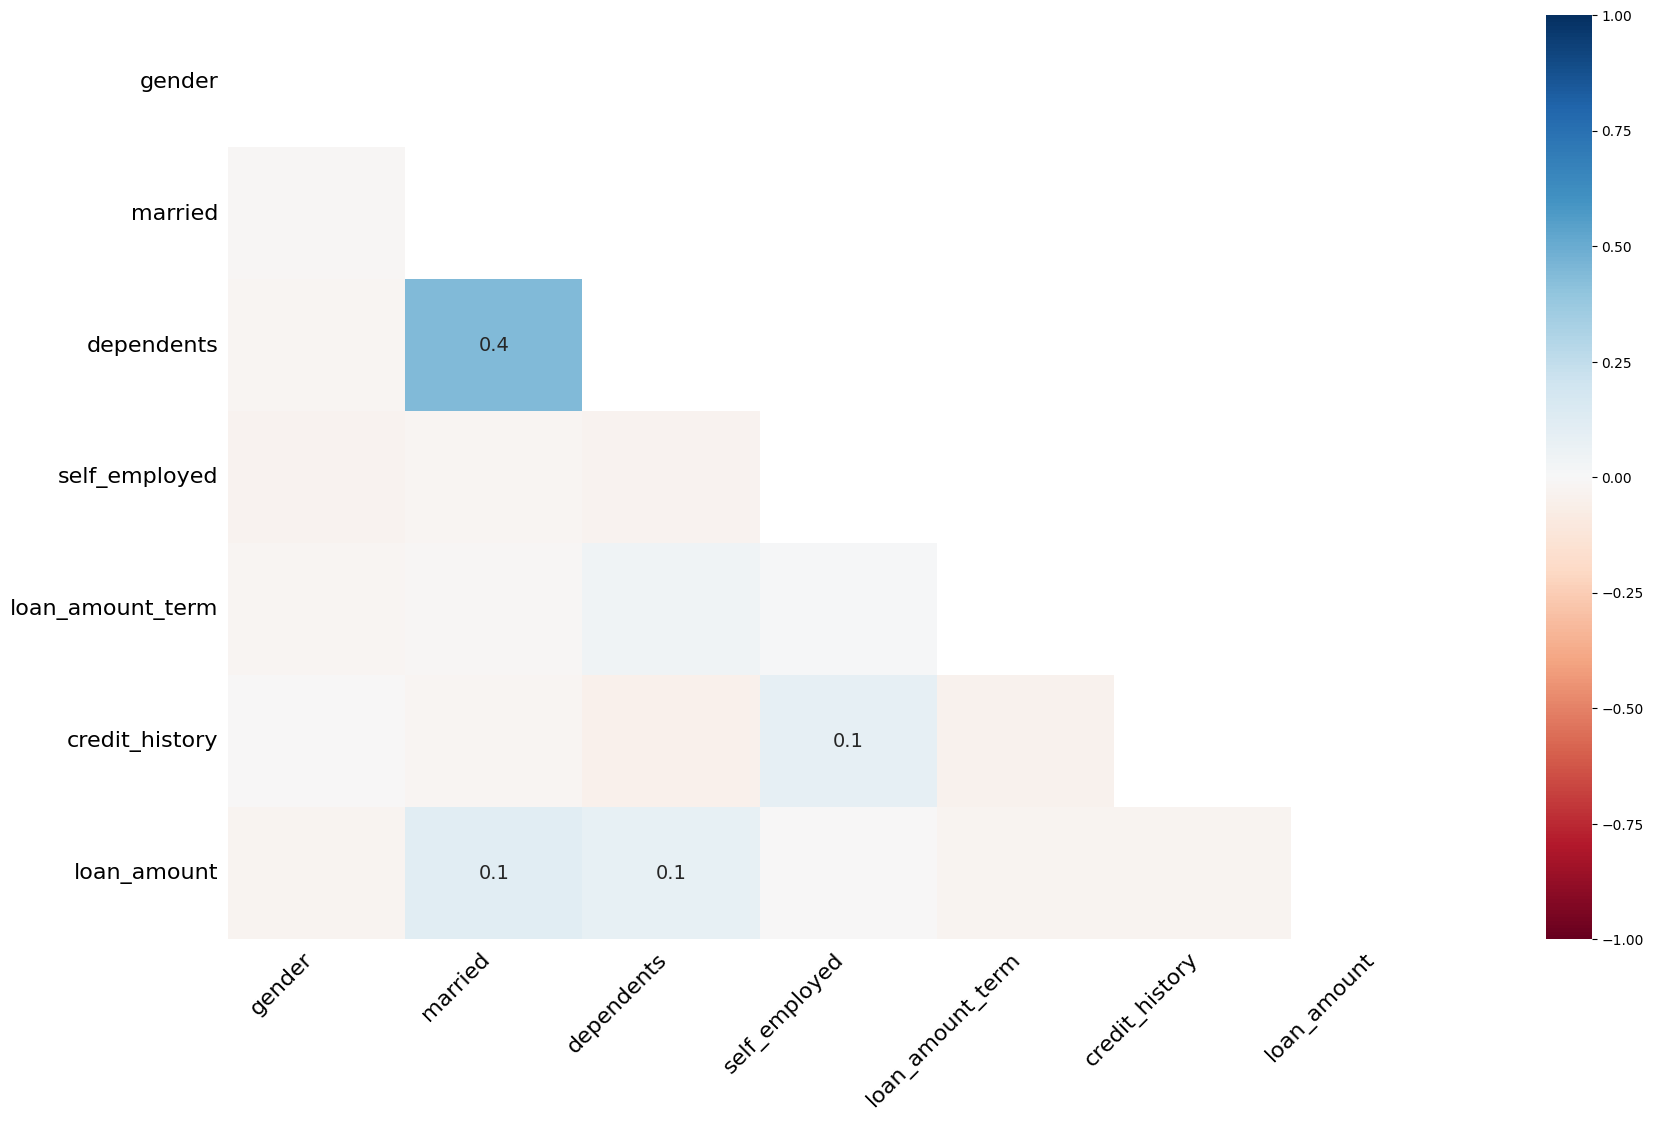

In [28]:
msno.heatmap(df[cat_cols+num_cols], labels=True)

From the above plot we can interpret relationships of missingness across few variables. There is a corralation of 0.4 between `dependents` and `married`, which makes sense as majority of times someone gets married first before having dependents. 

In [29]:
# Lets check where columns with missing data are related to eech other
missing_cols= [cols for cols in num_cols+cat_cols if df[cols].isnull().sum() > 0]
missing_cols

['loan_amount',
 'gender',
 'married',
 'dependents',
 'self_employed',
 'loan_amount_term',
 'credit_history']

<AxesSubplot: >

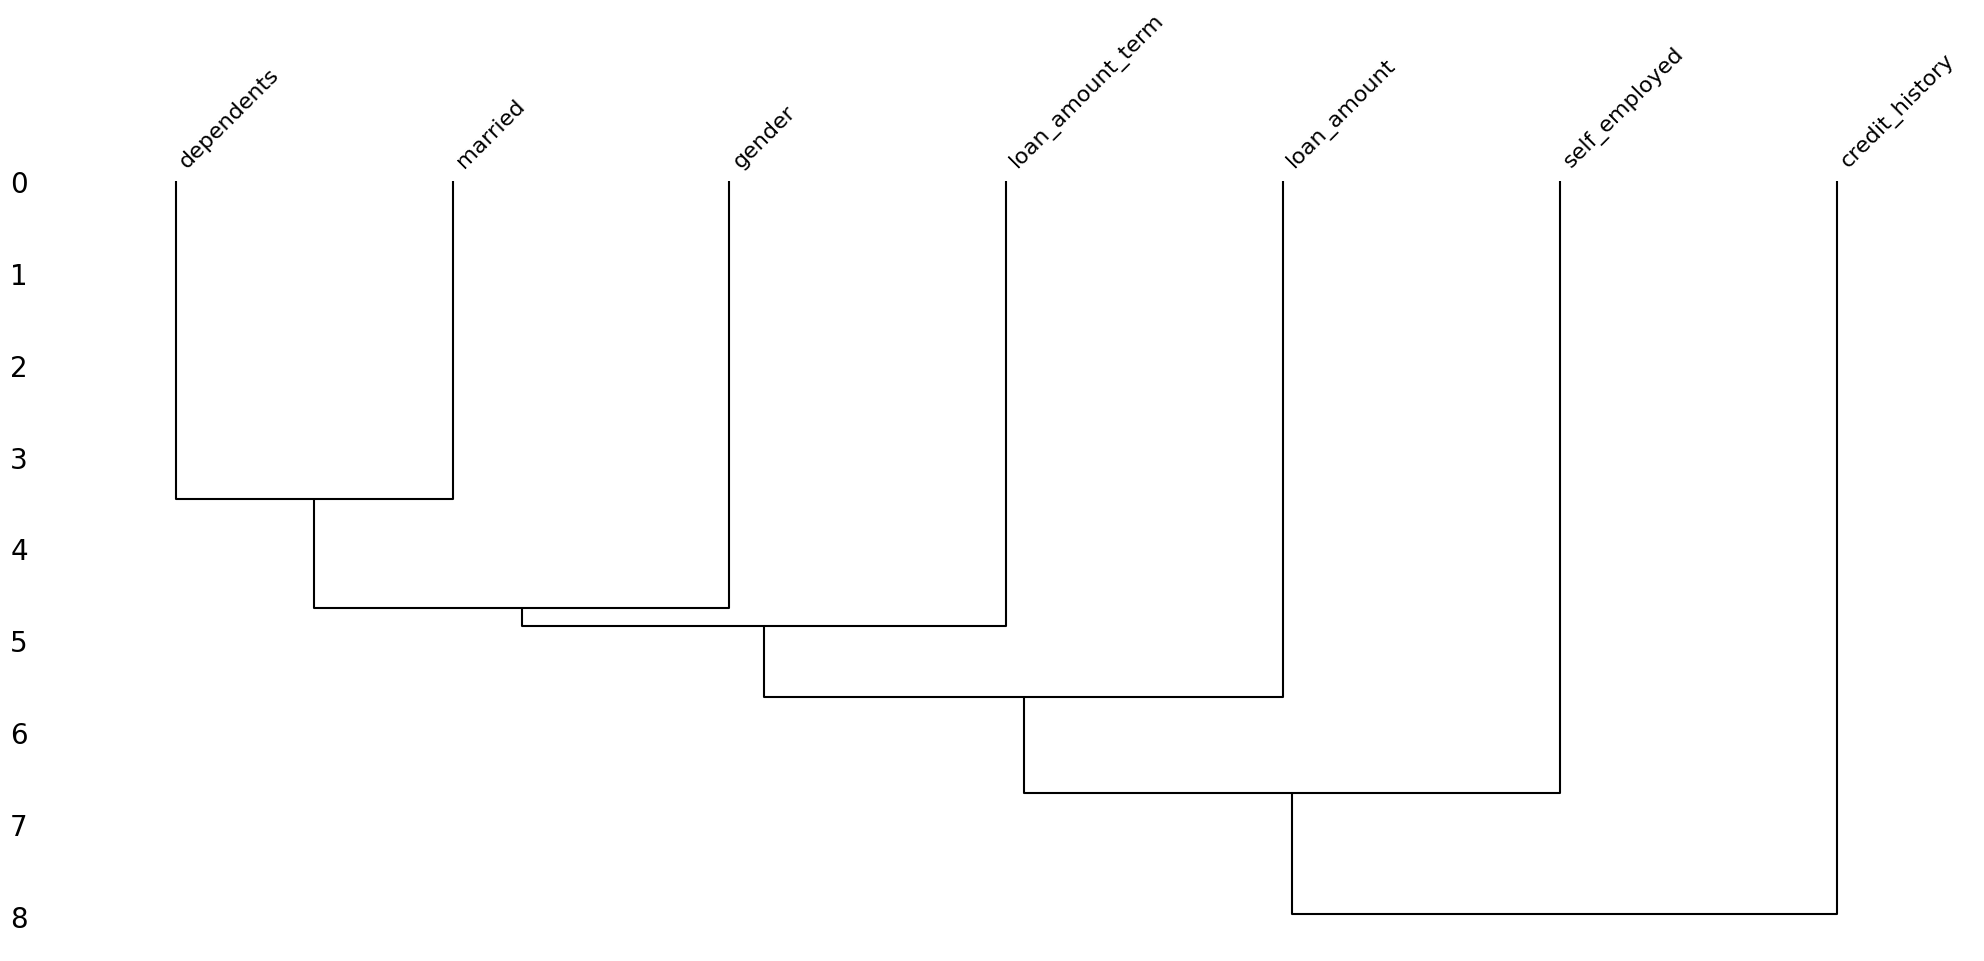

In [30]:
msno.dendrogram(df[missing_cols])

The dendogram method uses hierarchical clustering, and groups attributes together where missingness is associated with missingness of another variable or completeness is associated with completeness of another variable. We interpret the dendrogram based on a top-down approach, i.e., to focus on the height at which any two columns are connected together with matters of nullity. More the height, less will be the relation and vice versa is also True. For example missingness or presence of data in `credit_history` have no relationship with missingness or completeness of any other variable.

In [31]:
cat_cols

['gender',
 'married',
 'dependents',
 'graduate',
 'self_employed',
 'loan_amount_term',
 'credit_history',
 'property_area']

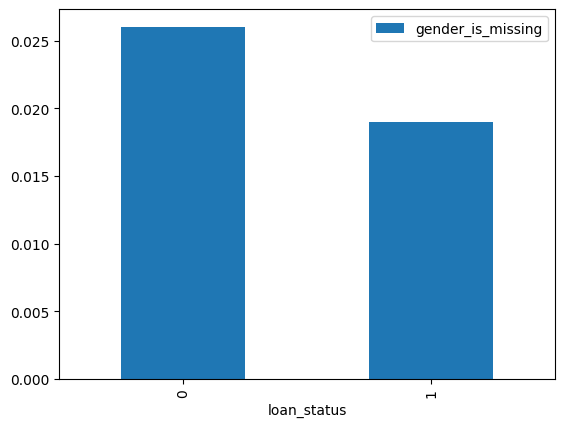

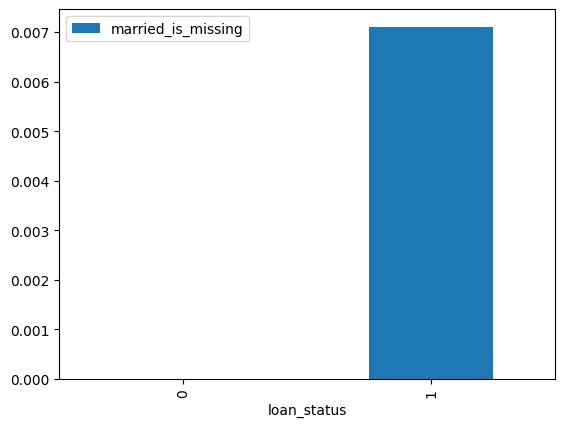

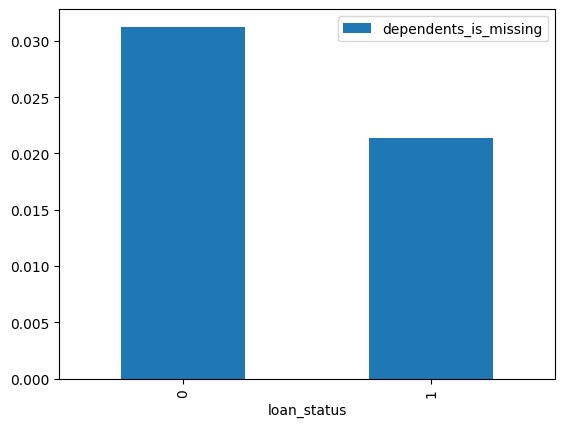

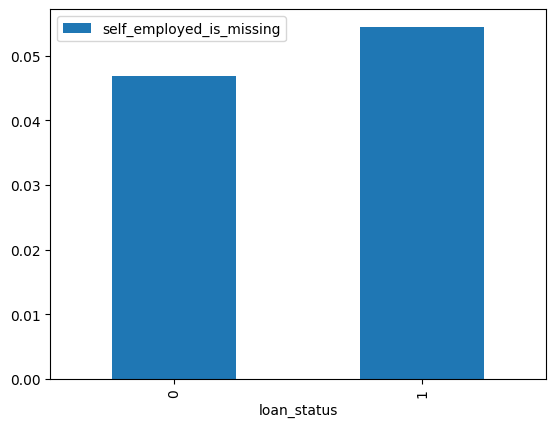

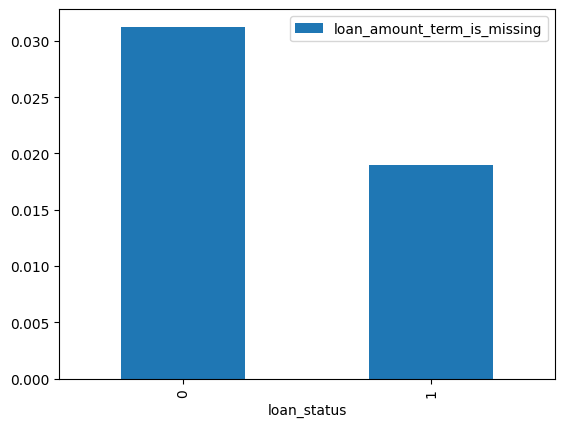

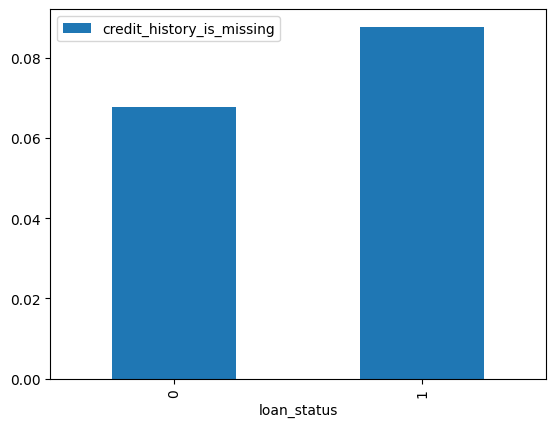

In [32]:
# Lets examine the missing categorical columns
cat_missing = [cols for cols in cat_cols if df[cols].isnull().sum() > 0]

def cat_missing_association_with_outcome(data, missing_data_column, outcome):
    """Function to plot missing association of categorical varibles with outcome"""
    
    df = data.copy()
    df[f"{missing_data_column}_is_missing"] = df[missing_data_column].isnull().astype(int)
    df.groupby([outcome]).agg({f"{missing_data_column}_is_missing": 'mean'}).plot.bar()
    
for cols in cat_missing:
    cat_missing_association_with_outcome(df, cols, target)

In [33]:
cat_cols

['gender',
 'married',
 'dependents',
 'graduate',
 'self_employed',
 'loan_amount_term',
 'credit_history',
 'property_area']

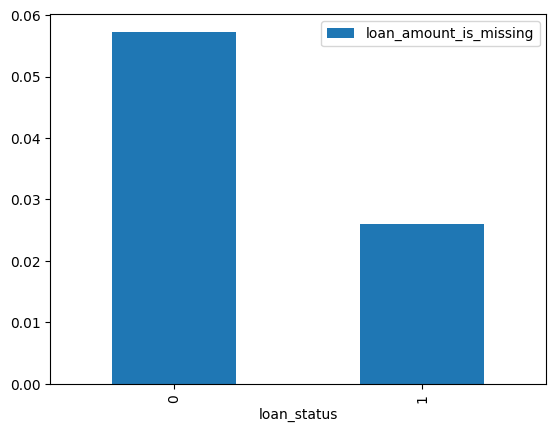

In [34]:
# Lets examine the missing numerical columns
num_missing = [cols for cols in missing_cols if cols not in cat_missing]

def num_missing_association_with_outcome(data, missing_data_column, outcome):
    """Function to plot missing association of categorical varibles with outcome"""
    
    df = data.copy()
    df[f"{missing_data_column}_is_missing"] = df[missing_data_column].isnull().astype(int)
    df.groupby([outcome]).agg({f"{missing_data_column}_is_missing": 'mean'}).plot.bar()


for cols in num_missing:
    num_missing_association_with_outcome(df, cols, target)

In [35]:
# Lets run feature importance by using global loan approval rate

In [36]:
global_loan_approval_rate = round(df[target].mean(),4)
print(global_loan_approval_rate)

0.6873


In [37]:
# Building the feature importances
feature_importances = []
for cols in cat_cols:
    for idx in df[cols].unique():
        loan_approval_rate = round(df[df[cols] == idx][target].mean(),4)

        feature_importance = abs(global_loan_approval_rate - loan_approval_rate)
        risk_ratio = round(loan_approval_rate/global_loan_approval_rate,4)
        feature_importances.append([cols, idx, feature_importance, risk_ratio])


feature_importance_df = pd.DataFrame(data=feature_importances, columns=["feature", "sub_feature", "importance", "risk_ratio"])

In [38]:
# Printing the feature importance
feature_importance_df.sort_values(by='risk_ratio', ascending=False)

,feature,sub_feature,importance,risk_ratio
17,loan_amount_term,month_10,0.3127,1.4550
21,loan_amount_term,month_5,0.3127,1.4550
26,loan_amount_term,month_1,0.3127,1.4550
27,credit_history,1.0,0.1085,1.1579
32,property_area,semi_urban,0.0809,1.1177
8,dependents,2,0.0652,1.0949
25,loan_amount_term,month_7,0.0627,1.0912
18,loan_amount_term,month_20,0.0627,1.0912
4,married,1.0,0.0288,1.0419
11,graduate,1,0.0210,1.0306


In [39]:
# Now lets get the mutual information
df_cat_clean = df[cat_cols + [target]].dropna()
def mutual_information(data_series) -> float:

    return mutual_info_score(data_series, df_cat_clean[target])

mi = df_cat_clean[cat_cols].apply(mutual_information)
mi.sort_values(ascending=False)

credit_history      0.135541
loan_amount_term    0.018338
property_area       0.014359
married             0.005400
graduate            0.003565
dependents          0.002475
gender              0.001647
self_employed       0.000356
dtype: float64

Short term loans are high predictors of whether loan will be granted (10, 1 and 5 month loans), and if someone didnt comply with creidt history policies, there loan is more likely to be declined, than accepted.

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_3207/2827503775.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[[cols for cols in df if cols not in  [id_col]]].corr(), annot=True)


<AxesSubplot: >

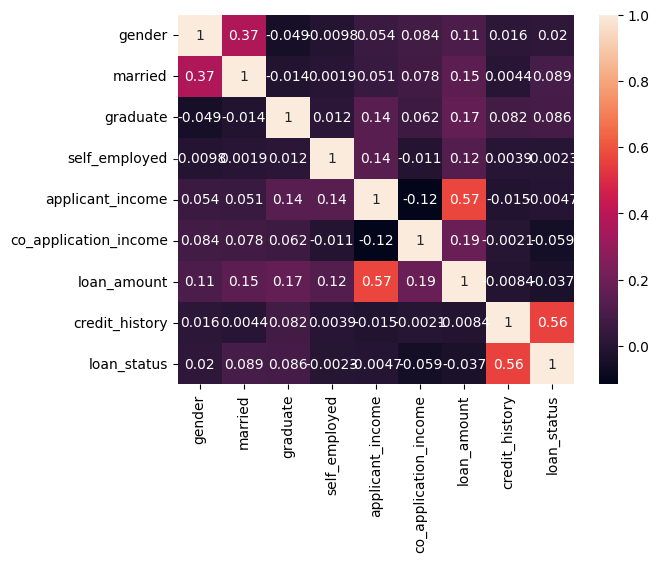

In [40]:
# Lets look at the correlation plots, and see if any numerical columns are correlated

sns.heatmap(df[[cols for cols in df if cols not in  [id_col]]].corr(), annot=True)

Now lets impute the missing values, for non categorical variables, lets add the word missing and for binary categorical variables and numerical variables we can impute with Mice Imputation

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from feature_engine.imputation.categorical import CategoricalImputer
from feature_engine.encoding import OneHotEncoder, RareLabelEncoder
from sklearn.model_selection import train_test_split

In [42]:
# Training data
X = df[[cols for cols in df if cols not in [id_col, target]]].copy()
y = df[target].values

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, random_state=42, test_size=round(len(y_test)/(X_train_full.shape[0]),4), stratify=y_train_full)

In [44]:
X_train.shape, X_test.shape, X_val.shape

((490, 11), (62, 11), (62, 11))

In [45]:
y_train.mean(), y_test.mean(), y_val.mean()

(0.6857142857142857, 0.6935483870967742, 0.6935483870967742)

In [46]:
columns = [cols for cols in X_train]
cat_non_binary_cols = ['property_area', 'dependents', 'loan_amount_term']
cat_imputer = CategoricalImputer(fill_value='missing', variables=cat_non_binary_cols)
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=8, variables=cat_non_binary_cols)
ohe_encoder = OneHotEncoder(variables=cat_non_binary_cols)

X_train[columns] = cat_imputer.fit_transform(X_train)
X_train = rare_encoder.fit_transform(X_train)
X_train = ohe_encoder.fit_transform(X_train)

X_test[columns] = cat_imputer.transform(X_test)
X_test = rare_encoder.transform(X_test)
X_test = ohe_encoder.transform(X_test)

X_val[columns] = cat_imputer.transform(X_val)
X_val = rare_encoder.transform(X_val)
X_val = ohe_encoder.transform(X_val)

/Users/bajajn/anaconda3/envs/mlzoomcamp-capstone-one/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable property_area is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Users/bajajn/anaconda3/envs/mlzoomcamp-capstone-one/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable dependents is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


In [47]:
# Scaling the data before imputing with Knn imputer
feature_cols = [cols for cols in X_train]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_val_scaled = X_val.copy()
scaler = StandardScaler()
X_train_scaled[feature_cols] = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)
X_val_scaled = scaler.transform(X_val_scaled)

In [48]:
# Bulding the KnnImputer
knn_imputer = KNNImputer(add_indicator=True)
X_train_imputed = knn_imputer.fit_transform(X_train_scaled)
X_test_imputed = knn_imputer.transform(X_test_scaled)
X_val_imputed = knn_imputer.transform(X_val_scaled)

/Users/bajajn/anaconda3/envs/mlzoomcamp-capstone-one/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
/Users/bajajn/anaconda3/envs/mlzoomcamp-capstone-one/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(


In [49]:
# Scaling the data back
X_train_transformed = pd.DataFrame(data=X_train_imputed, columns=knn_imputer.get_feature_names_out())
X_test_transformed = pd.DataFrame(data=X_test_imputed, columns=knn_imputer.get_feature_names_out())
X_val_transformed =  pd.DataFrame(data=X_val_imputed, columns=knn_imputer.get_feature_names_out())
X_train_transformed[feature_cols] = scaler.inverse_transform(X_train_transformed[feature_cols])
X_test_transformed[feature_cols] = scaler.inverse_transform(X_test_transformed[feature_cols])
X_val_transformed[feature_cols] = scaler.inverse_transform(X_val_transformed[feature_cols])

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

In [51]:
# Training the model using cross validation to ensure model is generalisable and can be used in a good setting
d_param_grid = {
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best'], 
    'max_depth' : [4,5,6,7,8,10,15,20],
    'min_samples_leaf' : [1,3,5,10],
    'min_samples_split': [2,6,10,20],
    'criterion' : ['gini', 'entropy'],
    'random_state' : [42], 
    'class_weight' : ['balanced', None],
}

d_clf = DecisionTreeClassifier()


# Training the models
d_clf_cv = GridSearchCV(estimator=d_clf, param_grid=d_param_grid, cv=5, scoring='roc_auc')
d_clf_cv.fit(X_train_transformed, y_train)

print("Decision tree optimised")


d_best_params = d_clf_cv.best_params_

print(f"Getting the best params which are {d_best_params}")

model = DecisionTreeClassifier(**d_best_params)
model.fit(X_train_transformed, y_train)

training_predictions_prob = model.predict_proba(X_train_transformed)
testing_predictions_prob = model.predict_proba(X_test_transformed)
val_predictions_prob = model.predict_proba(X_val_transformed)

training_predictions = model.predict(X_train_transformed)
testing_predictions = model.predict(X_test_transformed)
val_predictions = model.predict(X_val_transformed)

training_roc_auc = roc_auc_score(y_train, training_predictions_prob[:,1])
testing_roc_auc = roc_auc_score(y_test, testing_predictions_prob[:,1])
val_roc_auc = roc_auc_score(y_val, val_predictions_prob[:,1])

training_acc = accuracy_score(y_train, training_predictions)
testing_acc = accuracy_score(y_test, testing_predictions)
val_acc = accuracy_score(y_val, val_predictions)


print(f"Training roc is {training_roc_auc}, and testing roc is {testing_roc_auc}, val roc is {val_roc_auc} \n \
        training accuracy is {training_acc}, testing_acc is {testing_acc}, val_acc is {val_acc}")

Decision tree optimised
Getting the best params which are {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
Training roc is 0.7557591218305504, and testing roc is 0.6793145654834761, val roc is 0.6566707466340269 
         training accuracy is 0.7673469387755102, testing_acc is 0.7096774193548387, val_acc is 0.6612903225806451


In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

training_predictions_prob = model.predict_proba(X_train_transformed)
testing_predictions_prob = model.predict_proba(X_test_transformed)
val_predictions_prob = model.predict_proba(X_val_transformed)

training_predictions = model.predict(X_train_transformed)
testing_predictions = model.predict(X_test_transformed)
val_predictions = model.predict(X_val_transformed)

training_roc_auc = roc_auc_score(y_train, training_predictions_prob[:,1])
testing_roc_auc = roc_auc_score(y_test, testing_predictions_prob[:,1])
val_roc_auc = roc_auc_score(y_val, val_predictions_prob[:,1])

training_acc = accuracy_score(y_train, training_predictions)
testing_acc = accuracy_score(y_test, testing_predictions)
val_acc = accuracy_score(y_val, val_predictions)


print(f"Training roc is {training_roc_auc}, and testing roc is {testing_roc_auc}, val roc is {val_roc_auc} \n \
        training accuracy is {training_acc}, testing_acc is {testing_acc}, val_acc is {val_acc}")

Training roc is 1.0, and testing roc is 0.7594859241126071, val roc is 0.784577723378213 
         training accuracy is 1.0, testing_acc is 0.8225806451612904, val_acc is 0.8064516129032258
